# Showcases of `tfplot`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# override ipython style
from IPython.display import display_html, HTML, display
HTML("""<style>
.text_cell_render h1 { background: #b2f2bb; padding: 10px; }
.text_cell_render h2 { background: #ffec99; padding: 10px; }
</style>""")

In [3]:
# additional requirements:
#   scipy scikit-image Pillow seaborn

import numpy as np
from PIL import Image
import scipy.misc

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

from matplotlib import rcParams, rc
from IPython.core.pylabtools import figsize

%config InlineBackend.figure_format = 'retina'

In [5]:
import tfplot
tfplot.__version__

'0.3.0.dev0'

## Setup: Utilities and Data

In order to see the images generated from the plot ops, we introduce a simple utility function which takes a `Tensor` as an input and displays the resulting image after executing it in a TensorFlow session.

You may want to skip this section to have the showcase started.

In [6]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [7]:
def execute_op_as_image(op):
    """
    Evaluate the given `op` and return the content PNG image as `PIL.Image`.
    
    - If op is a plot op (e.g. RGBA Tensor) the image or
      a list of images will be returned
    - If op is summary proto (i.e. `op` was a summary op),
      the image content will be extracted from the proto object.
    """
    print ("Executing: " + str(op))
    ret = sess.run(op)
    plt.close()

    if isinstance(ret, np.ndarray):
        if len(ret.shape) == 3:
            # single image
            return Image.fromarray(ret)
        elif len(ret.shape) == 4:
            return [Image.fromarray(r) for r in ret]
        else:
            raise ValueError("Invalid rank : %d" % len(ret.shape))            
            
    elif isinstance(ret, (str, bytes)):
        from io import BytesIO
        s = tf.Summary()
        s.ParseFromString(ret)
        ims = []
        for i in range(len(s.value)):
            png_string = s.value[i].image.encoded_image_string
            im = Image.open(BytesIO(png_string))
            ims.append(im)
        plt.close()
        if len(ims) == 1: return ims[0]
        else: return ims
        
    else:
        raise TypeError("Unknown type: " + str(ret))

and some data:

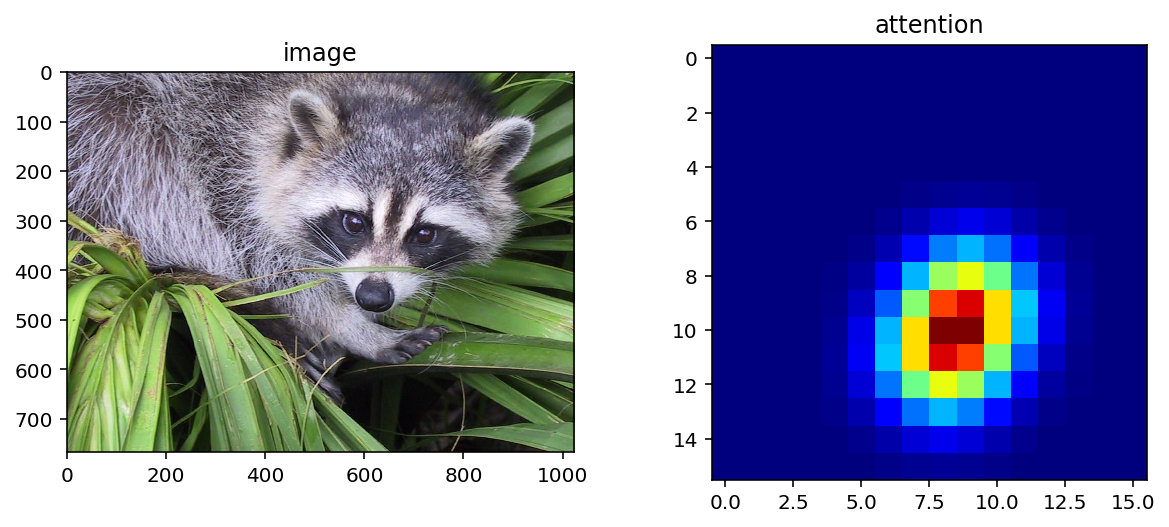

In [8]:
def fake_attention():
    import scipy.ndimage
    attention = np.zeros([16, 16], dtype=np.float32)
    attention[(11, 8)] = 1.0
    attention[(9, 9)] = 1.0
    attention = scipy.ndimage.filters.gaussian_filter(attention, sigma=1.5)
    return attention

sample_image = scipy.misc.face()
attention_map = fake_attention()

# display the data
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(sample_image); axs[0].set_title('image')
axs[1].imshow(attention_map, cmap='jet'); axs[1].set_title('attention')
plt.show()

And we finally wrap these numpy values into TensorFlow ops:

In [9]:
# the input to plot_op
image_tensor = tf.constant(sample_image, name='image')
attention_tensor = tf.constant(attention_map, name='attention')
print(image_tensor)
print(attention_tensor)

Tensor("image:0", shape=(768, 1024, 3), dtype=uint8)
Tensor("attention:0", shape=(16, 16), dtype=float32)


## 1. `autowrap` -- The Main End-User API

Use [`tfplot.autowrap`](https://tensorflow-plot.readthedocs.io/en/latest/api/tfplot.html#tfplot.autowrap) to design a custom plot function of your own.

### Decorator to define a TF op that draws plot

Executing: Tensor("plot_scatter:0", shape=(?, ?, 4), dtype=uint8)


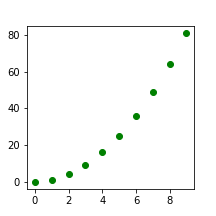

In [10]:
@tfplot.autowrap
def plot_scatter(x, y):
    # NEVER use plt.XXX, or matplotlib.pyplot.
    # Use tfplot.subplots() instead of plt.subplots() to avoid thread-safety issues.
    fig, ax = tfplot.subplots(figsize=(3, 3))
    ax.scatter(x, y, color='green')
    return fig

x = tf.constant(np.arange(10), dtype=tf.float32)
y = tf.constant(np.arange(10) ** 2, dtype=tf.float32)
execute_op_as_image(plot_scatter(x, y))

Sometimes, it is cumbersome to create instances of `fig` and `ax`. If you want to have them automatically injected, use a keyword argument named `fig` and/or `ax`:

Executing: Tensor("plot_scatter_1:0", shape=(?, ?, 4), dtype=uint8)


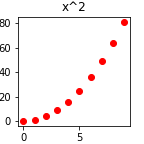

In [11]:
@tfplot.autowrap(figsize=(2, 2))
def plot_scatter(x, y, *, ax, color='red'):
    ax.set_title('x^2')
    ax.scatter(x, y, color=color)

x = tf.constant(np.arange(10), dtype=tf.float32)
y = tf.constant(np.arange(10) ** 2, dtype=tf.float32)
execute_op_as_image(plot_scatter(x, y))

We can create subplots as well:

Executing: Tensor("plot_image_and_attention:0", shape=(?, ?, 4), dtype=uint8)


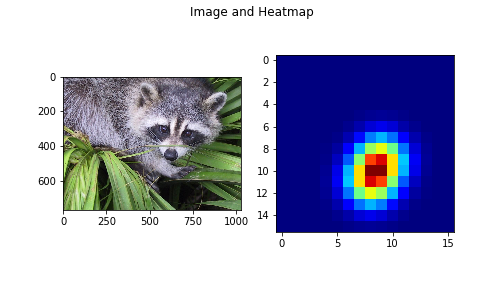

In [12]:
@tfplot.autowrap
def plot_image_and_attention(im, att, cmap=None):
    fig, axes = tfplot.subplots(1, 2, figsize=(7, 4))
    fig.suptitle('Image and Heatmap')
    axes[0].imshow(im)
    axes[1].imshow(att, cmap=cmap)
    return fig

op = plot_image_and_attention(sample_image, attention_map, cmap='jet')
execute_op_as_image(op)

## 3. Wrap any Matplotlib's AxesPlot or Seaborn Plot

### Matplotlib

Matplotlib provides a variety of plot functions on `AxesPlot`, `ax`.

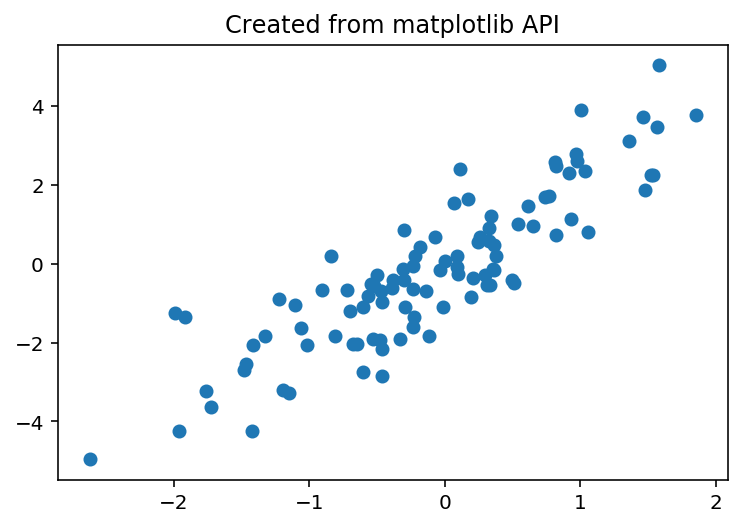

In [13]:
rs = np.random.RandomState(42)
x = rs.randn(100)
y = 2 * x + rs.randn(100)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title("Created from matplotlib API")
plt.show()

We can wrap the `Axes.scatter()` method as TensorFlow op as follows:

Executing: Tensor("scatter:0", shape=(?, ?, 4), dtype=uint8)


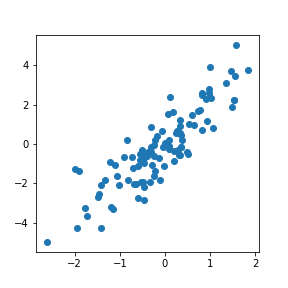

In [14]:
from matplotlib.axes import Axes
tf_scatter = tfplot.autowrap(Axes.scatter, figsize=(4, 4))

plot_op = tf_scatter(x, y)
execute_op_as_image(plot_op)

Executing: Tensor("scatter_1:0", shape=(?, ?, 4), dtype=uint8)


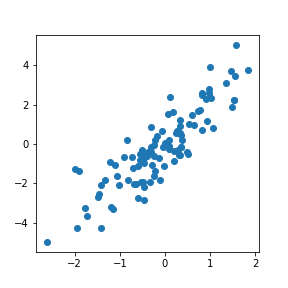

In [15]:
from matplotlib.axes import Axes
tf_scatter = tfplot.autowrap(Axes.scatter, figsize=(4, 4))

plot_op = tf_scatter(x, y)
execute_op_as_image(plot_op)

#### Seaborn

Seaborn provides good axis plot utilities that can be used out-of-box. Most of functions for drawing an `AxesPlot` will have the `ax=...` parameter.

In [16]:
import seaborn as sns

assert sns.__version__ >= '0.8', (
    'Use seaborn >= v0.8.0, otherwise `import seaborn as sns` will affect the default matplotlib style.'
)

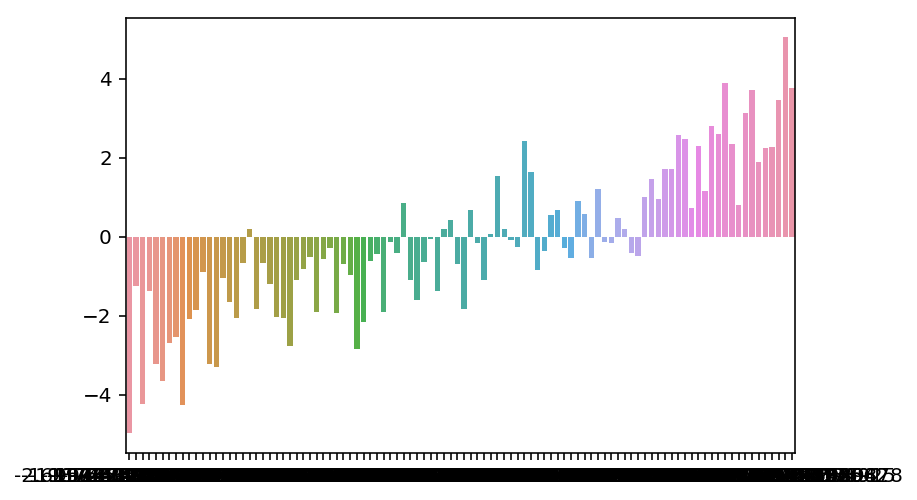

In [17]:
fig, ax = plt.subplots()
sns.barplot(x, y, ax=ax)
plt.show()

Executing: Tensor("barplot:0", shape=(?, ?, 4), dtype=uint8)


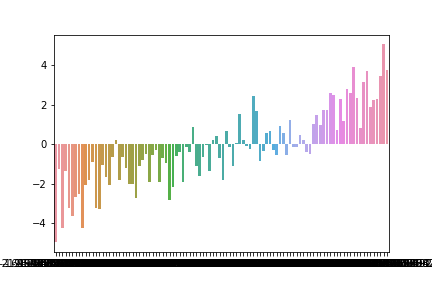

In [18]:
plot_op = tfplot.autowrap(sns.barplot)(x, y)

execute_op_as_image(plot_op)

Executing: Tensor("heatmap:0", shape=(?, ?, 4), dtype=uint8)


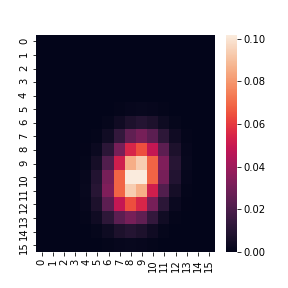

In [19]:
# wrap `sns.heatmap` as TensorFlow operation, with some additional default kwargs
tf_heatmap = tfplot.wrap_axesplot(sns.heatmap, figsize=(4,4))

execute_op_as_image(
    tf_heatmap(attention_map, cbar=True)
)

Executing: Tensor("HeatmapImage:0", shape=(?, ?, 4), dtype=uint8)


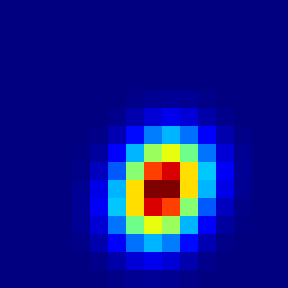

In [20]:
# print only heatmap figures other than axis, colorbar, etc.
tf_heatmap = tfplot.wrap_axesplot(sns.heatmap, figsize=(4,4), tight_layout=True,
                                  cmap='jet', cbar=False, xticklabels=False, yticklabels=False)

execute_op_as_image(
    tf_heatmap(attention_map, name='HeatmapImage')
)

## 4. Pre-defined plotting functions (`tfplot.contrib`)

The `tfplot.contrib` package contains some off-the-shelf functions for defining plotting operations.
This package provides some off-the-shelf functions that could be useful widely across many typical use cases.

Unfortunately, it may not provide super flexible and fine-grained customization points beyond the current parameters. If it does not fit what you want to get, then consider designing your own plotting functions.

In [21]:
import tfplot.contrib;
display_html(HTML("".join(
    "<li><b>{}</b></li>".format(fn, tfplot.contrib.__dict__[fn].__doc__) \
    for fn in sorted(tfplot.contrib.__all__)
)))

batch probmap probmap_simple

For example, `probmap` and `probmap_simple` create an image Tensor that visualizes a probability map:

Tensor("attention_op:0", shape=(16, 16), dtype=float32)
Executing: Tensor("probmap:0", shape=(?, ?, 4), dtype=uint8)


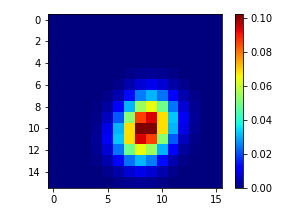

In [22]:
attention_op = tf.constant(attention_map, name="attention_op")
print(attention_op)

op = tfplot.contrib.probmap(attention_map, figsize=(4, 3))
execute_op_as_image(op)

Executing: Tensor("probmap_1:0", shape=(?, ?, 4), dtype=uint8)


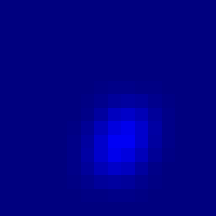

In [23]:
op = tfplot.contrib.probmap_simple(attention_map, figsize=(3, 3),
                                   vmin=0, vmax=1)
execute_op_as_image(op)

### Batch mode

In many cases, we may want to make plotting operations behave in a batch manner. You can use `tfplot.contrib.batch` to make those functions work in a batch mode:

Tensor("batch_tensor:0", shape=(5, 5, 5), dtype=float64)
Executing: Tensor("probmap_2/PlotImages:0", shape=(5, ?, ?, 4), dtype=uint8)


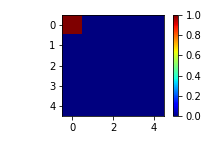

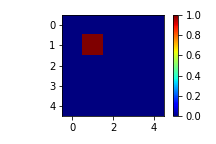

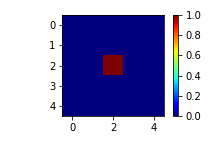

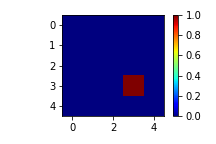

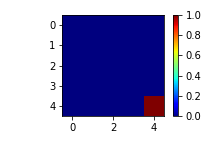

In [24]:
# batch version
N = 5
p = np.zeros([N, N, N])
for i in range(N):
    p[i, i, i] = 1.0

p = tf.constant(p, name="batch_tensor"); print(p)                      # (batch_size, 5, 5)
op = tfplot.contrib.batch(tfplot.contrib.probmap)(p, figsize=(3, 2))   # (batch_size, H, W, 4)

for im in execute_op_as_image(op):
    display(im)

<br><br><br>

## 5. Low-level APIs: `tfplot.plot()`

The following examples show the usage of the most general form of the API, `tfplot.plot()`. It has a very similar usage as [`tf.py_func()`](https://www.tensorflow.org/api_docs/python/tf/py_func).

Conceptually, we can draw any matplotlib plot as a TensorFlow op. One thing to remember is that the `plot_func` function (passed to `tfplot.plot()`) should be implemented using object-oriented APIs of matplotlib, not `pyplot.XXX` APIs (or `matplotlib.pyplot.XXX`) in order to avoid thread-safety issues.

### A basic example

Executing: Tensor("Plot:0", shape=(?, ?, 4), dtype=uint8)


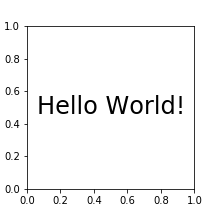

In [25]:
def test_figure():
    fig, ax = tfplot.subplots(figsize=(3, 3))
    ax.text(0.5, 0.5, "Hello World!",
            ha='center', va='center', size=24)
    return fig

plot_op = tfplot.plot(test_figure, [])
execute_op_as_image(plot_op)

### with Arguments

Executing: Tensor("Plot_1:0", shape=(?, ?, 4), dtype=uint8)


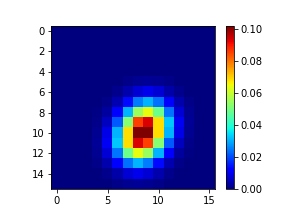

In [26]:
def figure_attention(attention):
    fig, ax = tfplot.subplots(figsize=(4, 3))
    im = ax.imshow(attention, cmap='jet')
    fig.colorbar(im)
    return fig

plot_op = tfplot.plot(figure_attention, [attention_tensor])
execute_op_as_image(plot_op)

### Examples of using kwargs

In [27]:
# the plot function can have additional kwargs for providing configuration points
def overlay_attention(attention, image,
                      alpha=0.5, cmap='jet'):
    fig = tfplot.Figure(figsize=(4, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.axis('off')
    fig.subplots_adjust(0, 0, 1, 1)  # get rid of margins
    
    H, W = attention.shape
    ax.imshow(image, extent=[0, H, 0, W])
    ax.imshow(attention, cmap=cmap,
              alpha=alpha, extent=[0, H, 0, W])
    return fig

Executing: Tensor("Plot_2:0", shape=(?, ?, 4), dtype=uint8)


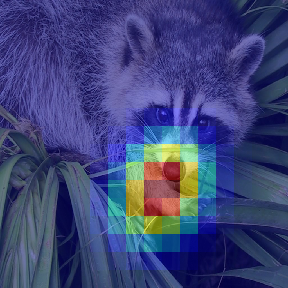

In [28]:
plot_op = tfplot.plot(overlay_attention, [attention_tensor, image_tensor])
execute_op_as_image(plot_op)

Executing: Tensor("Plot_3:0", shape=(?, ?, 4), dtype=uint8)


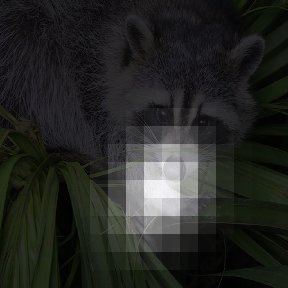

In [29]:
# the kwargs to `tfplot.plot()` are passed to the plot function (i.e. `overlay_attention`)
# during the execution of the plot operation.
plot_op = tfplot.plot(overlay_attention, [attention_tensor, image_tensor],
                      cmap='gray', alpha=0.8)
execute_op_as_image(plot_op)

### `plot_many()` -- the batch version

In [30]:
# make a fake batch
batch_size = 3
attention_batch = tf.random_gamma([batch_size, 7, 7], alpha=0.3, seed=42)
image_batch = tf.tile(tf.expand_dims(image_tensor, 0),
                      [batch_size, 1, 1, 1], name='image_batch')
print (attention_batch)
print (image_batch)

# plot_many()
plot_op = tfplot.plot_many(overlay_attention, [attention_batch, image_batch])
images = execute_op_as_image(plot_op)

Tensor("random_gamma/Maximum:0", shape=(3, 7, 7), dtype=float32)
Tensor("image_batch:0", shape=(3, 768, 1024, 3), dtype=uint8)
Executing: Tensor("PlotMany/PlotImages:0", shape=(3, ?, ?, 4), dtype=uint8)


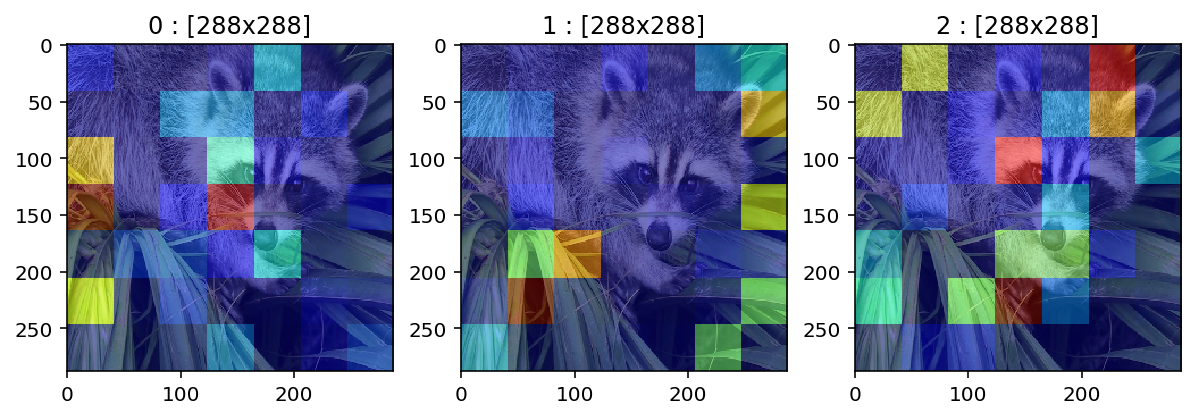

In [31]:
# just see the three images
_, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    axes[i].set_title("%d : [%dx%d]" % (i, images[i].height, images[i].width))
    axes[i].imshow(images[i])
plt.show()

### Wrap once, use it as a factory -- `tfplot.autowrap()` or `tfplot.wrap()`

Let's wrap the function `overlay_attention`, which

* takes a heatmap `attention` and a RGB image `overlay_image`
* and plots the heatmap on top of the image

as Tensors:

Executing: Tensor("overlay_attention:0", shape=(?, ?, 4), dtype=uint8)


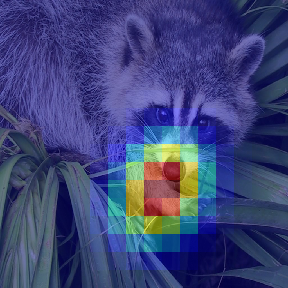

In [32]:
plot_op = tfplot.autowrap(overlay_attention)(attention_tensor, image_tensor)
execute_op_as_image(plot_op)

More clean style in a functional way!

### Batch example

In [33]:
tf_plot_attention = tfplot.wrap(overlay_attention, name='PlotAttention', batch=True)
print (tf_plot_attention)

<function wrap[__main__.overlay_attention] at 0x1252c60d0>


Then we can call the resulting `tf_plot_attention` function to build new TensorFlow ops:

In [34]:
plot_op = tf_plot_attention(attention_batch, image_batch)
images = execute_op_as_image(plot_op)
images

Executing: Tensor("PlotAttention/PlotImages:0", shape=(3, ?, ?, 4), dtype=uint8)


[<PIL.Image.Image image mode=RGBA size=288x288 at 0x124F01668>,
 <PIL.Image.Image image mode=RGBA size=288x288 at 0x124F01DD8>,
 <PIL.Image.Image image mode=RGBA size=288x288 at 0x124F01A58>]

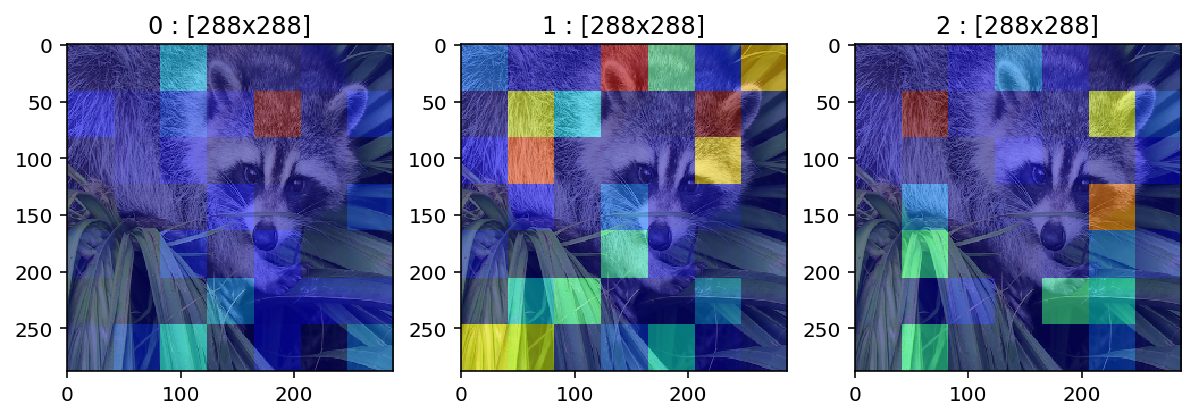

In [35]:
# just see the three images
_, axes = plt.subplots(1, 3, figsize=(10, 3))
for i in range(3):
    axes[i].set_title("%d : [%dx%d]" % (i, images[i].height, images[i].width))
    axes[i].imshow(images[i])
plt.show()

<br/><br/><br/><br/>

## 6. Demo of `tfplot.summary` (deprecated)

Finally, we can directly create a TensorFlow summary op from input tensors. This will give a similar API usage as `tf.summary.image()`, which is a shortcut to creating plot ops and then creating image summaries.

In [36]:
import tfplot.summary

### `tfplot.summary.plot()`

Tensor("plot_summary/ImageSummary:0", shape=(), dtype=string)
Executing: Tensor("plot_summary/ImageSummary:0", shape=(), dtype=string)


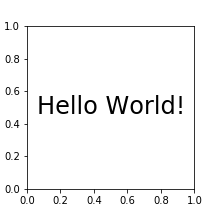

In [37]:
# Just directly add a single plot result into a summary
summary_op = tfplot.summary.plot("plot_summary", test_figure, [])
print(summary_op)
execute_op_as_image(summary_op)

### `tfplot.summary.plot_many()` -- the batch version

In [38]:
# batch of attention maps --> image summary
batch_size, H, W = 4, 4, 4
batch_attentions = np.zeros((batch_size, H, W), dtype=np.float32)
for b in range(batch_size):
    batch_attentions[b, b, b] = 1.0
    
# Note that tfplot.summary.plot_many() takes an input in a batch form
def figure_attention_demo2(attention):
    fig, ax = tfplot.subplots(figsize=(4, 3))
    im = ax.imshow(attention, cmap='jet')
    fig.colorbar(im)
    return fig
summary_op = tfplot.summary.plot_many("batch_attentions_summary", figure_attention_demo2,
                                      [batch_attentions], max_outputs=4)
print(summary_op)
images = execute_op_as_image(summary_op)

Tensor("batch_attentions_summary/ImageSummary:0", shape=(), dtype=string)
Executing: Tensor("batch_attentions_summary/ImageSummary:0", shape=(), dtype=string)


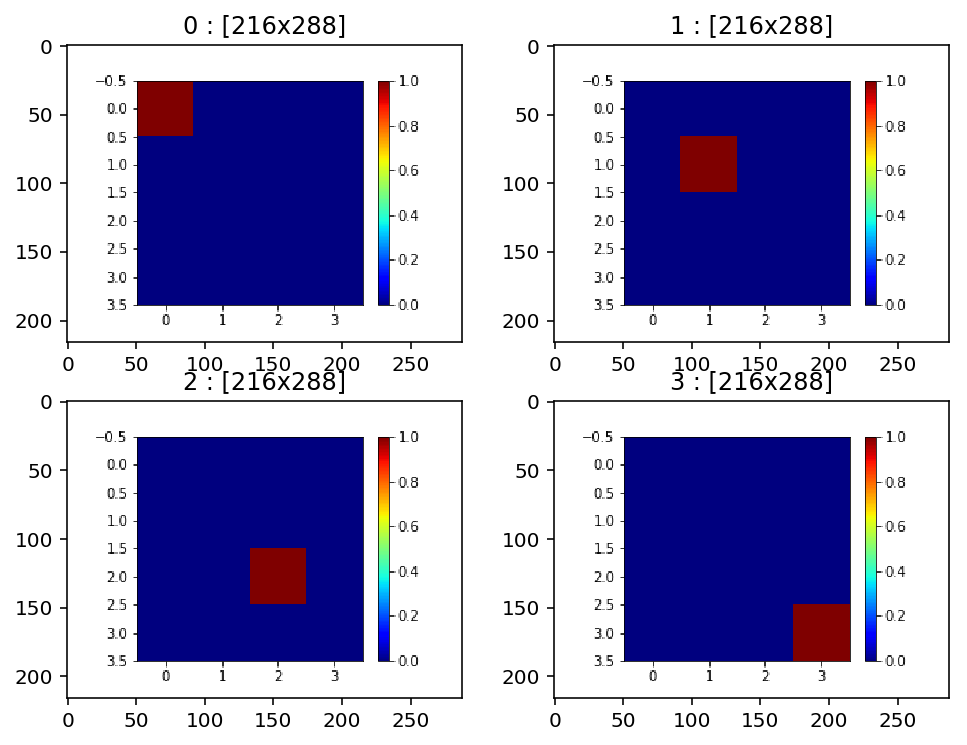

In [39]:
# just see the 4 images in the summary
_, axes = plt.subplots(2, 2, figsize=(8, 6))
for i in range(batch_size):
    axes[i//2, i%2].set_title("%d : [%dx%d]" % (i, images[i].height, images[i].width))
    axes[i//2, i%2].imshow(images[i])
plt.show()